## Optimizing Illumination with Least_Squares: A Lamp Power Distribution Problem

### Importing necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.optimize import minimize

### Initialize basic functions

In [2]:
def QR_factorization(A):
    """
    Performs QR factorization of a matrix A.
    
    Args:
        A: The input matrix to be factorized.
        
    Returns:
        Q: The orthogonal matrix Q.
        R: The upper triangular matrix R.
    """
    # Step 1: Compute the orthogonal basis using Gram-Schmidt process
    Q_transpose = np.array(gram_schmidt(A.T))  # Compute the transpose of A and apply Gram-Schmidt
    # Q_transpose is a matrix with orthogonal columns
    
    # Step 2: Calculate the upper triangular matrix R
    R = Q_transpose @ A  # Multiply the transpose of Q with A
    
    # Step 3: Calculate the orthogonal matrix Q
    Q = Q_transpose.T  # Take the transpose of Q_transpose
    
    # Step 4: Return the matrices Q and R
    return Q, R


def solve_via_backsub(A, b):
    """
    Solves a system of linear equations using back substitution after QR factorization.
    
    Args:
        A: The coefficient matrix.
        b: The vector of constants.
        
    Returns:
        x: The solution vector.
    """
    # Step 1: Perform QR factorization of A
    Q, R = QR_factorization(A)
    
    # Step 2: Transform the vector b
    b_tilde = Q.T @ b  # Multiply the transpose of Q with b
    
    # Step 3: Perform back substitution
    x = back_subst(R, b_tilde)  # Solve the system using back substitution
    
    # Step 4: Return the solution vector
    return x

def back_subst(R, b_tilde):
    """
    Performs back substitution to solve an upper triangular system of equations.
    
    Args:
        R: The upper triangular matrix.
        b_tilde: The transformed vector.
        
    Returns:
        x: The solution vector.
    """
    n = R.shape[0]  # Get the number of rows/columns in R
    x = np.zeros(n)  # Create an array of zeros for the solution vector
    
    # Step 1: Perform back substitution
    for i in reversed(range(n)):
        x[i] = b_tilde[i]  # Assign the transformed value to the solution vector
        for j in range(i+1, n):
            x[i] = x[i] - R[i, j] * x[j]  # Subtract the appropriate terms
        x[i] = x[i] / R[i, i]  # Divide by the diagonal element of R
    
    # Step 2: Return the solution vector
    return x

def gram_schmidt(a):
    """
    Applies the Gram-Schmidt process to obtain an orthogonal basis.
    
    Args:
        a: The input vectors as a list or array.
        
    Returns:
        q: The orthogonal basis as a list.
    """
    q = []  # Initialize an empty list for the orthogonal basis
    
    # Step 1: Apply the Gram-Schmidt process
    for i in range(len(a)):
        # Orthogonalization
        q_tilde = a[i]  # Initialize q_tilde with the current vector a[i]
        for j in range(len(q)):
            q_tilde = q_tilde - (q[j] @ a[i]) * q[j]  # Subtract the projection of a[i] onto each orthogonal vector q[j]
        
        # Step 2: Test for dependence
        if np.sqrt(sum(q_tilde**2)) <= 1e-10:
            # The vectors are linearly dependent
            print('Vectors are linearly dependent.')
            print('GS algorithm terminates at iteration ', i+1)
            return q  # Return the current orthogonal basis
        
        # Step 3: Normalization
        else:
            q_tilde = q_tilde / np.sqrt(sum(q_tilde**2))  # Normalize q_tilde
            q.append(q_tilde)  # Append q_tilde to the orthogonal basis list q
    
    # Step 4: The vectors are linearly independent
    print('Vectors are linearly independent.')
    return q  # Return the final orthogonal basis

### Question 1

Vectors are linearly independent.


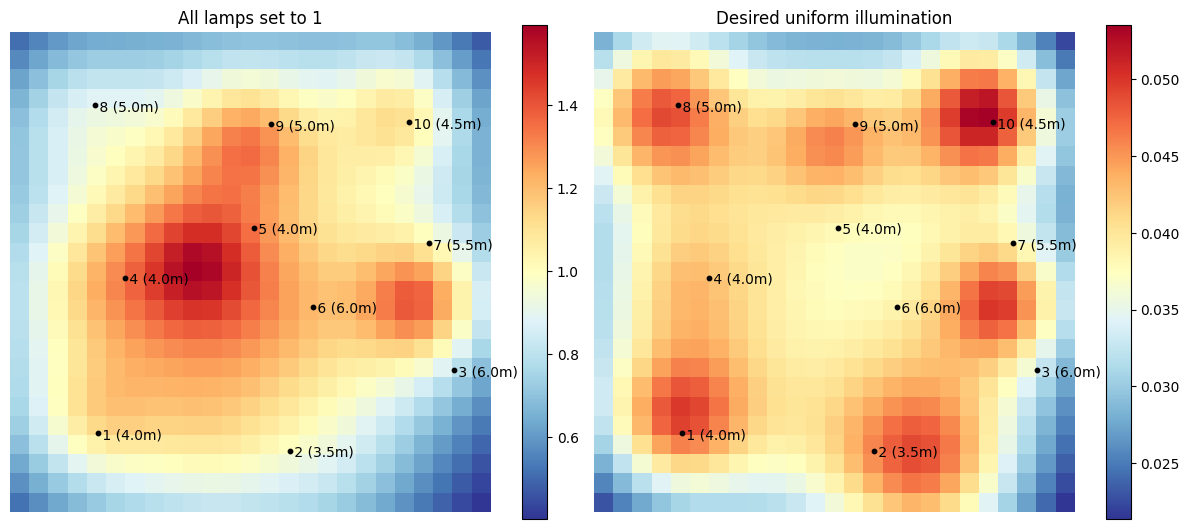

RMS error for all lamps set to 1: 0.24174131853807876
RMS error for desired uniform illumination: 0.005615619253710425


In [3]:
# number of lamps
n = 10

# x, y positions of lamps and height above floor
lamps = np.array([[4.1, 20.4, 4], [14.1, 21.3, 3.5], [22.6, 17.1, 6], [5.5, 12.3, 4.0], [12.2, 9.7, 4.0],
                  [15.3, 13.8, 6], [21.3, 10.5, 5.5], [3.9, 3.3, 5.0], [13.1, 4.3, 5.0], [20.3, 4.2, 4.5]])

N = 25  # grid size
m = N * N  # number of pixels

# construct m x 2 matrix with coordinates of pixel centers
pixels = np.hstack([np.outer(np.arange(0.5, N, 1), np.ones(N)).reshape(m, 1),
                    np.outer(np.ones(N), np.arange(0.5, N, 1)).reshape(m, 1)])

# The m x n matrix A maps lamp powers to pixel intensities.
# A[i,j] is inversely proportional to the squared distance of
# lamp j to pixel i.
A = np.zeros((m, n))
for i in range(m):
    for j in range(n):
        A[i, j] = 1.0 / (np.linalg.norm(np.hstack([pixels[i, :], 0]) - lamps[j, :]) ** 2)

A = (m / np.sum(A)) * A  # scale elements of A

lamp_powers_all_1 = np.ones(n)

# Desired uniform illumination
desired_illumination = np.ones(m) * (1 / m) ** 0.5

# Solve least squares problem
x = solve_via_backsub(A, desired_illumination)
lamp_powers_uniform = x

# Compute illumination for all lamps set to 1
illumination_all_1 = A @ lamp_powers_all_1

# Compute illumination for desired uniform illumination
illumination_uniform = A @ lamp_powers_uniform

# Set up figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot illumination for all lamps set to 1
im1 = ax1.imshow(illumination_all_1.reshape(N, N), cmap=cm.RdYlBu_r)
ax1.set_title('All lamps set to 1')
ax1.axis('off')

# Add colorbar with adjusted pad
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.06)

# Scatter plot for lamp positions
lamp_labels = [' {}'.format(i+1) for i in range(n)]
for i in range(n):
    ax1.scatter(lamps[i, 0], lamps[i, 1], color='black', marker='o', s=10, label=lamp_labels[i])
    ax1.annotate(f'{lamp_labels[i]} ({lamps[i, 2]}m)', (lamps[i, 0], lamps[i, 1] + 0.3))

# Plot illumination for desired uniform illumination
im2 = ax2.imshow(illumination_uniform.reshape(N, N), cmap=cm.RdYlBu_r)
ax2.set_title('Desired uniform illumination')
ax2.axis('off')

# Add colorbar with adjusted pad
cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.06)

# Scatter plot for lamp positions
for i in range(n):
    ax2.scatter(lamps[i, 0], lamps[i, 1], color='black', marker='o', s=10, label=lamp_labels[i])
    ax2.annotate(f'{lamp_labels[i]} ({lamps[i, 2]}m)', (lamps[i, 0], lamps[i, 1] + 0.3))

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# RMS error for all lamps set to 1
rms_all_1 = np.sqrt(np.sum((illumination_all_1 - 1) ** 2) / m)

# RMS error for desired uniform illumination
rms_uniform = np.sqrt(np.sum((illumination_uniform - desired_illumination) ** 2) / m)

print('RMS error for all lamps set to 1:', rms_all_1)
print('RMS error for desired uniform illumination:', rms_uniform)

### Question 2

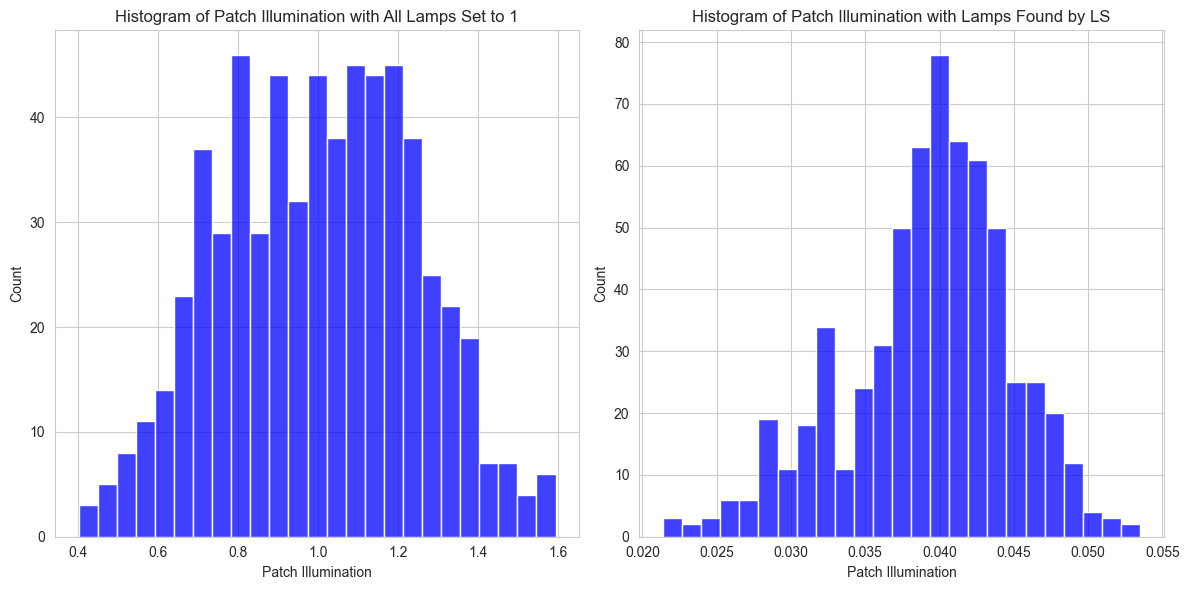

In [4]:
# Set style
sns.set_style('whitegrid')

# Set up figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for all lamps set to 1
sns.histplot(data=A @ np.ones(n), bins=25, kde=False, color='blue', ax=ax1)
ax1.set_title('Histogram of Patch Illumination with All Lamps Set to 1')
ax1.set_xlabel('Patch Illumination')
ax1.set_ylabel('Count')

# Plot histogram for lamps found by LS
sns.histplot(data=A @ x, bins=25, kde=False, color='blue', ax=ax2)
ax2.set_title('Histogram of Patch Illumination with Lamps Found by LS')
ax2.set_xlabel('Patch Illumination')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

### Question 3

To solve the given problem, we need to add two constraints to the optimization problem:
   1. Total energy consumption of the lamps should be equal to 10.
   2. None of the lamps should have negative power.
    
We can formulate this as a constrained optimization problem as follows:
 * minimize ||Ax - b||^2 subject to
 * sum(x) = 10 # Total energy consumption constraint\
 * x >= 0 # Non-negative power constraint

where A is the m x n matrix that maps lamp powers to pixel intensities, x is the n-dimensional vector of lamp powers, and b is the desired uniform illumination.

To solve this problem, we can use any optimization method that can handle constraints. Here, we will use the scipy.optimize.minimize function with the SLSQP method which supports constraints.




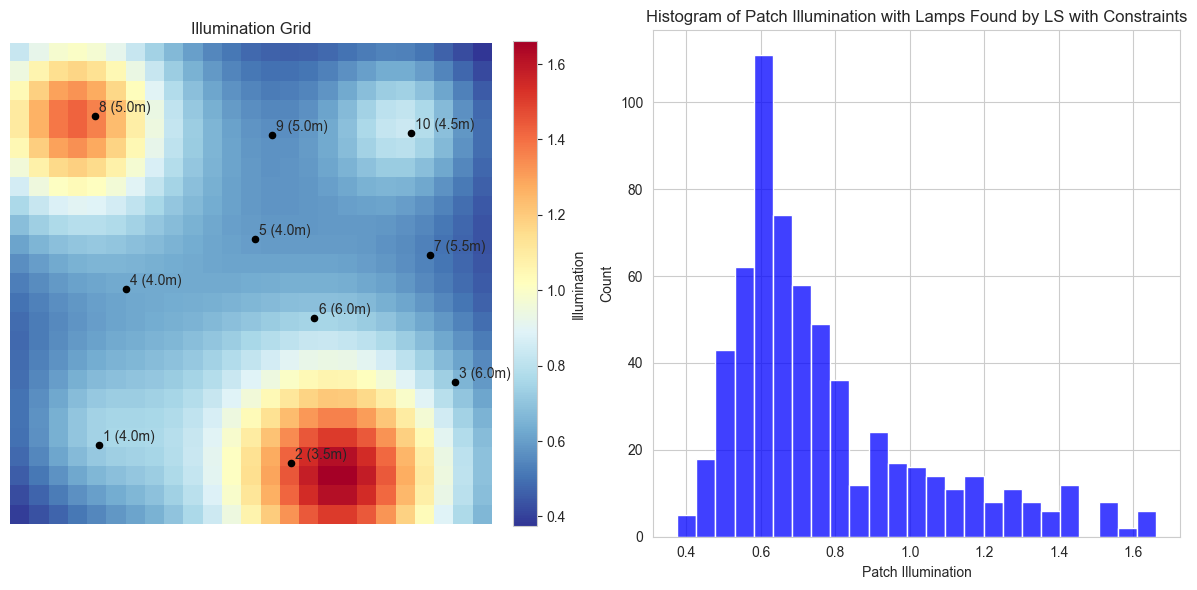

In [5]:
# Define the objective function
def objective(x, A, b):
    """
    Objective function to minimize.

    Args:
        x (ndarray): Lamp powers.
        A (ndarray): Matrix mapping lamp powers to pixel intensities.
        b (ndarray): Desired pixel intensities.

    Returns:
        float: Objective function value.
    """
    return np.sum((A @ x - b)**2)

# Define the constraint functions
def power_constraint(x):
    """
    Power constraint function.

    Args:
        x (ndarray): Lamp powers.

    Returns:
        float: Value of the constraint function.
    """
    return np.sum(x) - 10

def non_negative_constraint(x):
    """
    Non-negative constraint function.

    Args:
        x (ndarray): Lamp powers.

    Returns:
        ndarray: Array of non-negative constraint values.
    """
    return x

# Set up constraints
constraints = [{'type': 'eq', 'fun': power_constraint},
               {'type': 'ineq', 'fun': non_negative_constraint}]

# Solve the constrained optimization problem
x0 = np.ones(n)  # Initial guess for lamp powers
result = minimize(objective, x0, args=(A, desired_illumination), constraints=constraints, method='SLSQP')

# Extract the optimal lamp powers
lamp_powers = result.x

# Compute illumination for optimal lamp powers
illumination_optimal = A @ lamp_powers

# Reshape illumination vector into 2D grid
illumination_grid = illumination_optimal.reshape((N, N))

# Set style
sns.set_style('whitegrid')

# Set up figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display illumination grid
im = ax1.imshow(illumination_grid, cmap='RdYlBu_r')
ax1.axis('off')
ax1.set_title('Illumination Grid')

# Add color bar
cbar = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Illumination')

# Plot lamps in the order specified by lamps list
for i in range(len(lamps)):
    ax1.scatter(lamps[i, 0], lamps[i, 1], color='black', s=20)
    ax1.annotate(str(i + 1) + ' (' + str(lamps[i, 2]) + 'm)', (lamps[i, 0], lamps[i, 1]), xytext=(3, 3),
                 textcoords='offset points')

# Plot histogram for lamps found by LS
sns.histplot(data=A @ lamp_powers, bins=25, kde=False, color='blue', ax=ax2)
ax2.set_title('Histogram of Patch Illumination with Lamps Found by LS with Constraints')
ax2.set_xlabel('Patch Illumination')
ax2.set_ylabel('Count')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

The minimize function takes as input the objective function, initial guess for the lamp powers, and the constraints. The objective function is the same as before. The constraints are defined using the constraints list. The first constraint is the total energy consumption constraint, which is an equality constraint. The second constraint is the non-negative power constraint, which is an inequality constraint.

The optimal lamp powers are returned in the result.x attribute.

In [6]:
 result.x 

array([ 8.95986940e-01,  6.40567364e-12,  5.36134910e+00,  8.39820299e-13,
        5.80785820e-12,  4.17416536e-13,  6.75114803e-13,  3.07563284e+00,
       -3.19579133e-12,  6.67031126e-01])

### Question 4  ###

To find new points for the lamps to beat the RMS error of the first question, we can run a random search algorithm to explore different positions of lamps within the area. The lamps can be placed at any height between 4 and 6 meters and the total energy of the lamps should be 10. Also, none of the lamps should have negative energy. Once we find a better solution, we can create a colormap picture of the illumination and a histogram of the intensities of the pixels of the area.

Best RMS error: 0.6413581470356942


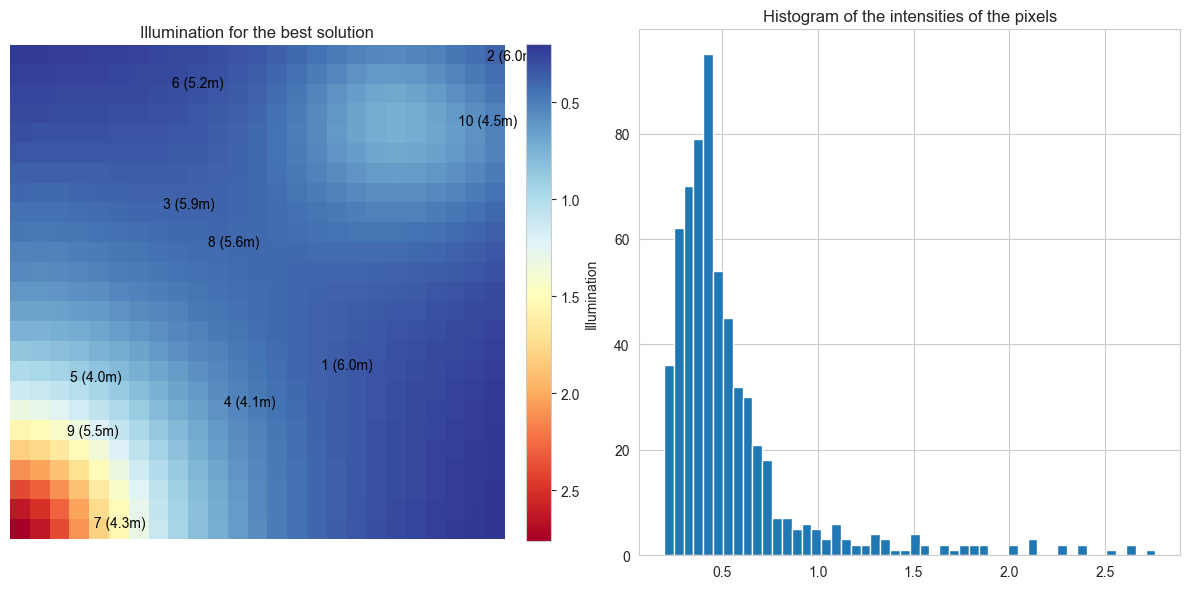

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# number of lamps
n = 10

# define function to generate random positions for the lamps
def generate_random_positions(n):
    x = np.random.uniform(0, 25, size=n)
    y = np.random.uniform(0, 25, size=n)
    z = np.random.uniform(4, 6, size=n)
    return np.vstack([x, y, z]).T

best_lamp_positions = None
best_rms_error = np.inf

# run random search algorithm
for i in range(10000):
    # generate random positions for the lamps
    lamps = generate_random_positions(n)

    # construct m x n matrix A
    A = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            A[i, j] = 1.0 / (np.linalg.norm(np.hstack([pixels[i, :], 0]) - lamps[j, :])**2)
    A = (m / np.sum(A)) * A  # scale elements of A

    # Solve the constrained optimization problem
    x0 = np.ones(n)
    result = minimize(objective, x0, args=(A, desired_illumination), method='SLSQP', constraints=constraints)

    # check if solution is valid and better than previous solutions
    if result.success and np.all(result.x >= 0) and power_constraint(result.x) == 0:
        rms_error = (sum((A @ result.x - desired_illumination)**2) / m)**0.5
        if rms_error < best_rms_error:
            best_lamp_positions = lamps
            best_lamp_powers = result.x
            best_rms_error = rms_error

print('Best RMS error:', best_rms_error)

# compute illumination for the best solution
A = np.zeros((m, n))
for i in range(m):
    for j in range(n):
        A[i, j] = 1.0 / (np.linalg.norm(np.hstack([pixels[i, :], 0]) - best_lamp_positions[j, :])**2)
A = (m / np.sum(A)) * A  # scale elements of A
illumination = A @ best_lamp_powers

# plot colormap picture of the illumination and histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot colormap picture of the illumination
im = ax1.imshow(illumination.reshape(N, N), cmap='RdYlBu_r')
ax1.set_title('Illumination for the best solution')
ax1.axis('off')


# Add color bar
cbar = plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
cbar.ax.invert_yaxis()
cbar.ax.set_ylabel('Illumination')

# Add the number of each point and meters
for i, lamp in enumerate(best_lamp_positions):
    ax1.text(lamp[0], lamp[1], f'{i+1} ({lamp[2]:.1f}m)', color='black', fontsize=10, ha='center', va='center')

# Plot histogram of the intensities of the pixels
ax2.hist(illumination, bins=50)
ax2.set_title('Histogram of the intensities of the pixels')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()